In [1]:
import models
import constants
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
folder = './data/scenarios/'

In [6]:
test_scenario_constant = pd.read_csv(folder+'00012_constant_130lux.csv', sep=",", decimal=".",header=0,names=['hours', 'irradiance_mel'])
test_secnario_morning_peak = pd.read_csv(folder+'00711_morning_peak_250lux_peak3p5x.csv', sep=",", decimal=".",header=0,names=['hours', 'irradiance_mel'])
test_scenario_afternoon_peak = pd.read_csv(folder+'08922_afternoon_peak_2080lux_peak3p5x.csv', sep=",", decimal=".",header=0,names=['hours', 'irradiance_mel'])
test_scenario_daylight = pd.read_csv(folder+'11092_daylight_5930lux.csv', sep=",", decimal=".",header=0,names=['hours', 'irradiance_mel'])
# test_scenario_constant

In [ ]:
import os
import pickle
import time
import pandas as pd
from tqdm.notebook import tqdm

# Dictionary to store results
scenario_results = {}

# Create a timestamp for the filename
timestamp = time.strftime("%Y%m%d-%H%M%S")
output_filename = f"scenario_results_{timestamp}.pkl"

# Get all CSV files in the folder
csv_files = [f for f in os.listdir(folder) if f.endswith('.csv')]

# Process each file
for file in tqdm(csv_files):
    # Extract scenario name from filename (without extension)
    scenario_name = os.path.splitext(file)[0]
    
    # Load the scenario data
    scenario = pd.read_csv(folder + file, sep=",", decimal=".",
                          header=0, names=['hours', 'irradiance_mel'])
    
    # Run the model
    sol, t = models.model_run(10, 2400, scenario, debug=False)
    
    # Store the solution with the scenario name as key
    scenario_results[scenario_name] = {
        'solution': sol,
        'time': t,
        'scenario_data': scenario
    }

    # Save incrementally after each file in case of crash
    with open(output_filename, 'wb') as f:
        pickle.dump(scenario_results, f)
    
print(f"Processed {len(scenario_results)} scenarios")

  0%|          | 0/11500 [00:00<?, ?it/s]

/Users/ulbrical/GitHub/arousal-dynamics-model/models.py:202: RuntimeWarning: divide by zero encountered in power
  + power(
/Users/ulbrical/GitHub/arousal-dynamics-model/models.py:202: RuntimeWarning: divide by zero encountered in power
  + power(
/Users/ulbrical/GitHub/arousal-dynamics-model/models.py:202: RuntimeWarning: divide by zero encountered in power
  + power(
/Users/ulbrical/GitHub/arousal-dynamics-model/models.py:202: RuntimeWarning: divide by zero encountered in power
  + power(
/Users/ulbrical/GitHub/arousal-dynamics-model/models.py:202: RuntimeWarning: divide by zero encountered in power
  + power(
/Users/ulbrical/GitHub/arousal-dynamics-model/models.py:202: RuntimeWarning: divide by zero encountered in power
  + power(
/Users/ulbrical/GitHub/arousal-dynamics-model/models.py:202: RuntimeWarning: divide by zero encountered in power
  + power(
/Users/ulbrical/GitHub/arousal-dynamics-model/models.py:202: RuntimeWarning: divide by zero encountered in power
  + power(
/Users/u

Processed 11500 scenarios


In [6]:
# Load previously saved results
import pickle

output_filename = './scenario_results_20250507-211749.pkl'

# Load the results
with open(output_filename, 'rb') as f:
    scenario_results = pickle.load(f)

In [37]:
# go through the loaded results and calculate KSS, AMT6, and RHO_B
# find scnarios in each category that have the same KSS, AMT6, and RHO_B
from tqdm.notebook import tqdm

metrics = {}
for scenario_name, data in tqdm(scenario_results.items()):
    sol = data['solution']
    t = data['time']
    scenario_data = data['scenario_data']
    
    # Calculate KSS, AMT6, and RHO_B
    H = sol[:, 2]
    X = sol[:, 3]
    Y = sol[:, 4]
    P = sol[:, 5]
    Theta_L = sol[:, 6]
    rho_b = sol[:, 8]
    C = models.circadian_drive_v(X,Y)
    KSS = models.alertness_measure_v(C, H, Theta_L)
    aMT6s = [models.urinary_excretion_rate(rho_b, t, time) for time in t]
    irradiance = [models.irradiance(time, scenario_data, 6, 22) for time in t]
    
    metrics[scenario_name] = {
        'KSS': KSS,
        'aMT6s': aMT6s,
        'RHO_B': rho_b,
        'irradiance': irradiance,
        'time': t,
        'scenario_data': scenario_data
    }


  0%|          | 0/11500 [00:00<?, ?it/s]

In [38]:
# Find one scenario in each category (constant, morning peak, afternoon peak, daylight) that has the same KSS, AMT6, and RHO_B (or close enough)
# Pick the first scenario in category constant, then loop over the other categories and find the first scenario that has the same KSS, AMT6, and RHO_B

# filter metrics' scenario name that include the word constant
constant_scenarios = {k: v for k, v in metrics.items() if 'constant' in k}
morning_peak_scenarios = {k: v for k, v in metrics.items() if 'morning_peak' in k}
afternoon_peak_scenarios = {k: v for k, v in metrics.items() if 'afternoon_peak' in k}
daylight_scenarios = {k: v for k, v in metrics.items() if 'daylight' in k}

# len(constant_scenarios), len(morning_peak_scenarios), len(afternoon_peak_scenarios), len(daylight_scenarios)

# first_key = next(iter(constant_scenarios))
# first_value = constant_scenarios[first_key]
# print(f"First scenario: {first_key}")
# print(f"KSS : {first_value['KSS']}")
# print(f"AMT6: {first_value['AMT6']}")
# print(f"RHO_B: {first_value['RHO_B']}")

In [ ]:

for scenario_name, data in tqdm(constant_scenarios.items()):
    KSS = data['KSS']
    AMT6 = data['aMT6s']
    RHO_B = data['RHO_B']
    
    # Find the first scenario in each category that has the same KSS, AMT6, and RHO_B
    for category, scenarios in [('morning_peak', morning_peak_scenarios), 
                                ('afternoon_peak', afternoon_peak_scenarios), 
                                ('daylight', daylight_scenarios)]:
        for name, metrics_data in scenarios.items():
            if np.isclose(KSS, metrics_data['KSS'], atol=0.005).all():
                print(f"Found matching scenario: {name} in category {category} for {scenario_name}")
                break

  0%|          | 0/300 [00:00<?, ?it/s]

Found matching scenario: 01359_morning_peak_630lux_peak4p5x in category morning_peak for 00070_constant_710lux
Found matching scenario: 04336_morning_peak_2380lux_peak5p5x in category morning_peak for 00236_constant_2370lux
Found matching scenario: 09010_afternoon_peak_2130lux_peak5p0x in category afternoon_peak for 00236_constant_2370lux
Found matching scenario: 11094_daylight_5950lux in category daylight for 00236_constant_2370lux
Found matching scenario: 02927_morning_peak_1550lux_peak6p5x in category morning_peak for 00167_constant_1680lux
Found matching scenario: 08120_afternoon_peak_1610lux_peak2p0x in category afternoon_peak for 00167_constant_1680lux
Found matching scenario: 04029_morning_peak_2200lux_peak5p0x in category morning_peak for 00222_constant_2230lux
Found matching scenario: 08825_afternoon_peak_2020lux_peak6p0x in category afternoon_peak for 00222_constant_2230lux
Found matching scenario: 01253_morning_peak_570lux_peak2p5x in category morning_peak for 00061_constant

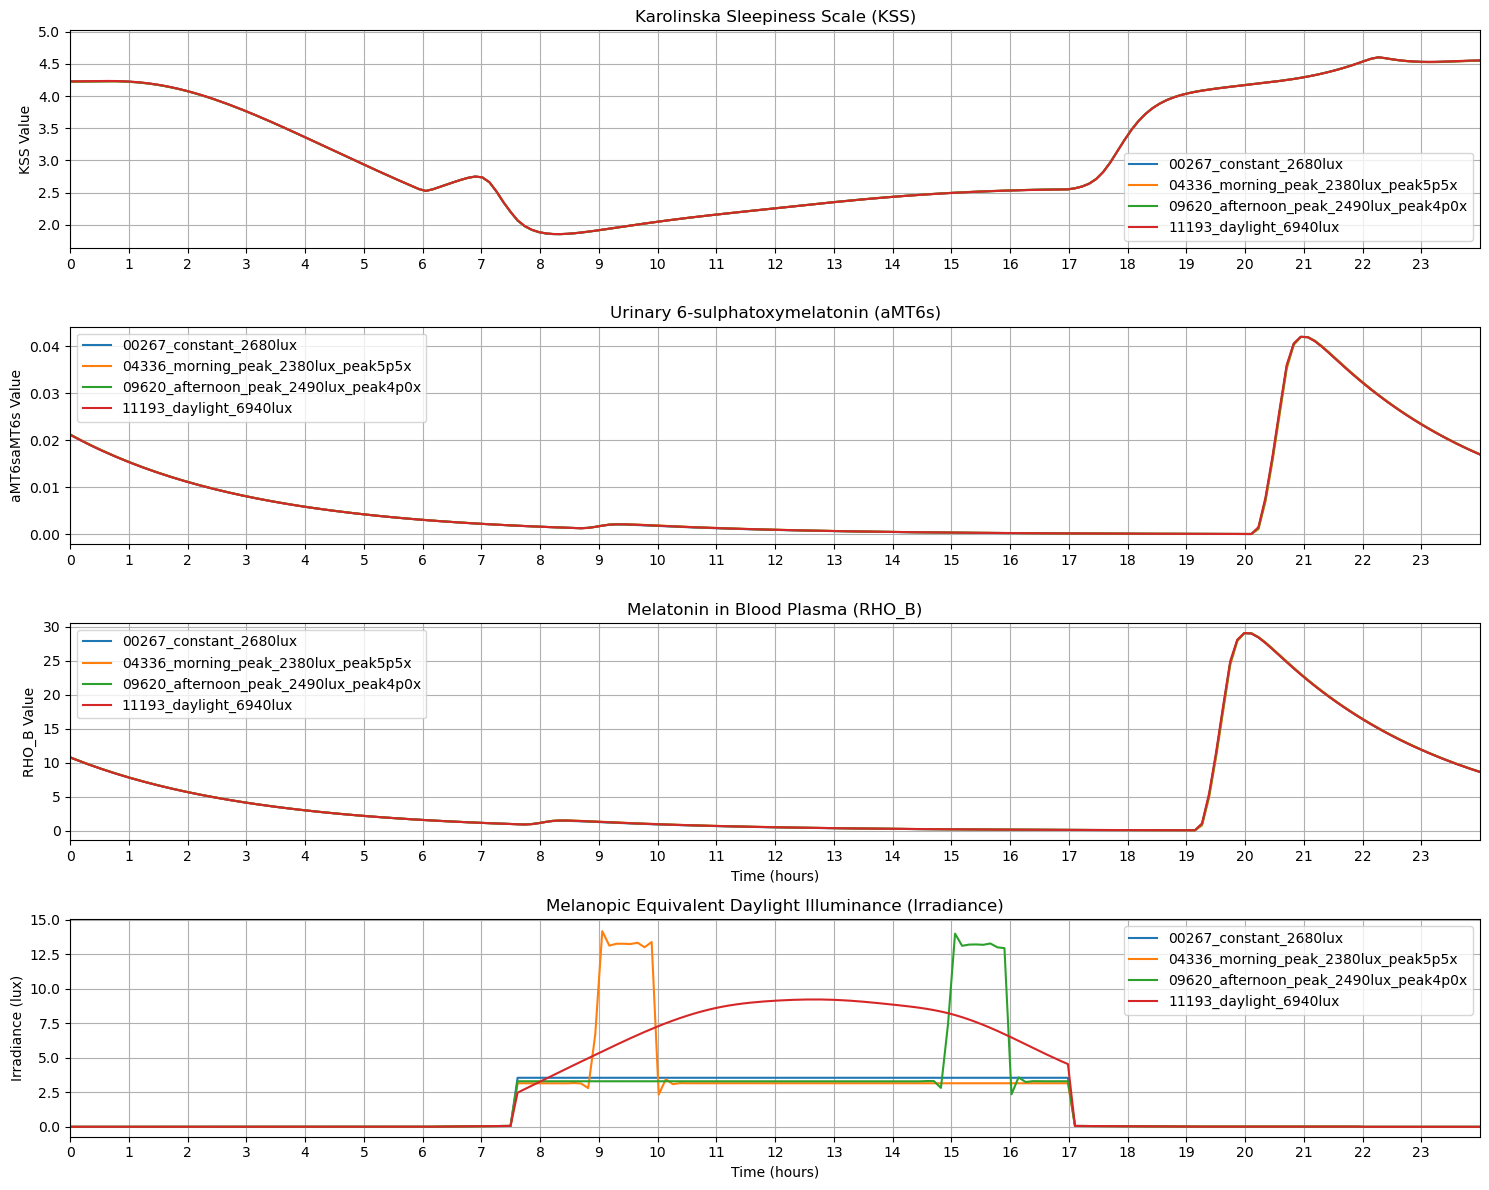

In [44]:
# Define the scenario names for easier reference
labels = {
    'constant': '00092_constant_930lux',
    'morning_peak': '01704_morning_peak_830lux_peak7p0x',
    'afternoon_peak': '06879_afternoon_peak_880lux_peak2p0x',
    'daylight': '10692_daylight_1930lux'
} # tol = 0.01

labels = {
    'constant': '00267_constant_2680lux',
    'morning_peak': '04336_morning_peak_2380lux_peak5p5x',
    'afternoon_peak': '09620_afternoon_peak_2490lux_peak4p0x',
    'daylight': '11193_daylight_6940lux'
} # tol = 0.005

# Get the common time vector
t = metrics['00070_constant_710lux']['time']
t_hours = t / 3600  # Convert seconds to hours

# Create a figure with three subplots
plt.figure(figsize=(15, 12))

# Plot 1: KSS for all scenarios
plt.subplot(4, 1, 1)
for label, scenario in labels.items():
    plt.plot(t_hours, metrics[scenario]['KSS'], label=scenario)
plt.title('Karolinska Sleepiness Scale (KSS)')
plt.ylabel('KSS Value')
plt.legend()
plt.grid(True)
plt.xlim(48, 72)
plt.xticks(range(48, 72, 1), range(0, 24, 1))

# Plot 2: AMT6 for all scenarios
plt.subplot(4, 1, 2)
for label, scenario in labels.items():
    plt.plot(t_hours, metrics[scenario]['aMT6s'], label=scenario)
plt.title('Urinary 6-sulphatoxymelatonin (aMT6s)')
plt.ylabel('aMT6saMT6s Value')
plt.legend()
plt.grid(True)
plt.xlim(48, 72)
plt.xticks(range(48, 72, 1), range(0, 24, 1))

# Plot 3: RHO_B for all scenarios
plt.subplot(4, 1, 3)
for label, scenario in labels.items():
    plt.plot(t_hours, metrics[scenario]['RHO_B'], label=scenario)
plt.title('Melatonin in Blood Plasma (RHO_B)')
plt.xlabel('Time (hours)')
plt.ylabel('RHO_B Value')
plt.legend()
plt.grid(True)
plt.xlim(48, 72)
plt.xticks(range(48, 72, 1), range(0, 24, 1))

# Plot 4: Irradiance for all scenarios
plt.subplot(4, 1, 4)  # Added new subplot for irradiance
for label, scenario in labels.items():
    plt.plot(t_hours, metrics[scenario]['irradiance'], label=scenario)
plt.title('Melanopic Equivalent Daylight Illuminance (Irradiance)')
plt.xlabel('Time (hours)')
plt.ylabel('Irradiance (lux)')
plt.legend()
plt.grid(True)
plt.xlim(48, 72)
plt.xticks(range(48, 72, 1), range(0, 24, 1))

plt.tight_layout()
plt.show()